In [11]:
import os
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
from pandas import read_csv

print(torch.cuda.is_available())
print(torch.cuda.current_device())
os.chdir('/home/lukerowe/projects/def-gtzan/lukerowe/ismir2021_supp/notebooks')

True
0


In [8]:
# Run chord quality stratification
!python3 ../data/stratify_acr_dataset.py

100%|████████████████████████████████████████| 243/243 [00:00<00:00, 281.84it/s]
973
1217
973
1217
974
1217
974
1217
974
1217


Humphrey Bello Folds


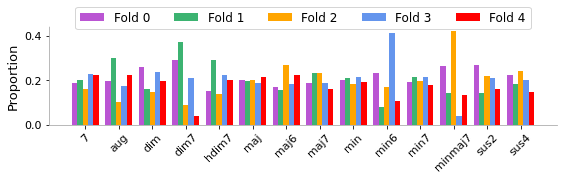

Stratified Folds


<Figure size 432x288 with 0 Axes>

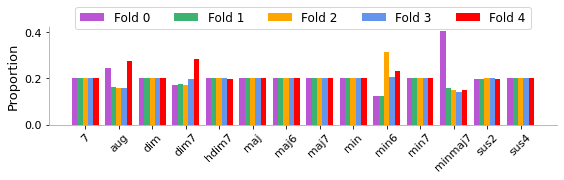

In [15]:
# Visualize stratified folds
tfont = {'fontsize':16}
lfont = {'fontsize':13}
axfont = {'fontsize':11}
legfont = {'fontsize':12}

chord_quality_indices = {0:'7', 1:'aug', 2:'dim', 3:'dim7',
                         4:'hdim7', 5:'maj', 6:'maj6', 7:'maj7',
                         8:'min', 9:'min6', 10:'min7', 11:'minmaj7',
                         12:'sus2', 13:'sus4', 168: 'N', 169: 'X'}
labels = ['7', 'aug', 'dim', 'dim7', 'hdim7', 'maj', 'maj6', 'maj7', 'min', 'min6','min7', 'minmaj7', 'sus2', 'sus4']

humphrey_bello_folds_path = '../data/humphrey_bello_folds'
stratified_folds_path = 'stratified_folds'

def get_fold_statistics(fold_path):
    fold_statistics = {}
    for i in range(5):
        ids = read_csv(os.path.join(fold_path, 'test{:02d}.csv'.format(i)), header=None, names=['data_id'])
        li = [0] * 14
        for k, ind in enumerate(ids['data_id']):

            npz = np.load(os.path.join("../../MARL/marl_data/pump", "{}.npz".format(ind)))
            chord_tag = npz['chord_tag/chord'][0,:,0]

            chord_tag[chord_tag < 168] = chord_tag[chord_tag < 168] % 14

            for j in range(14):
                li[j] += np.sum(chord_tag == j) 
        
        fold_statistics[i] = np.array(li)
    
    return fold_statistics

humphrey_bello_fold_statistics = get_fold_statistics(humphrey_bello_folds_path)  
stratified_fold_statistics = get_fold_statistics(stratified_folds_path)

def subcategorybar(X, vals, colors, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge", label="Fold {}".format(i), color=colors[i])   
    plt.xticks(_X, X, rotation=45, **axfont)
    ax.set_yticks([0,0.2, 0.4])
    plt.yticks(**axfont)
    ax.set_ylabel('Proportion', **lfont)
    
def visualize_folds(fold_statistics):
    vals = [fold_statistics[i] for i in range(5)]
    dataset_totals = vals[0] + vals[1] + vals[2] + vals[3] + vals[4]
    # Get proportions
    vals = [vals[i] / dataset_totals for i in range(5)]
    colors = ['mediumorchid', 'mediumseagreen', 'orange', 'cornflowerblue', 'red']
    subcategorybar(labels, vals, colors)
    for i, spine in enumerate(ax.spines.values()):
        if i == 0 or i == 2:
            spine.set_edgecolor('darkgrey')
        else:
            spine.set_edgecolor('white')
    ax.grid(False)
    plt.legend(bbox_to_anchor=(0.5,1.2), loc = 'upper center', borderaxespad=0, ncol=5, **legfont)
    plt.tight_layout()
    plt.show()

print("Humphrey Bello Folds")
fig, ax = plt.subplots(figsize=(8,2.75))
visualize_folds(humphrey_bello_fold_statistics)
plt.clf()
print("Stratified Folds")
fig, ax = plt.subplots(figsize=(8,2.75))
visualize_folds(stratified_fold_statistics)

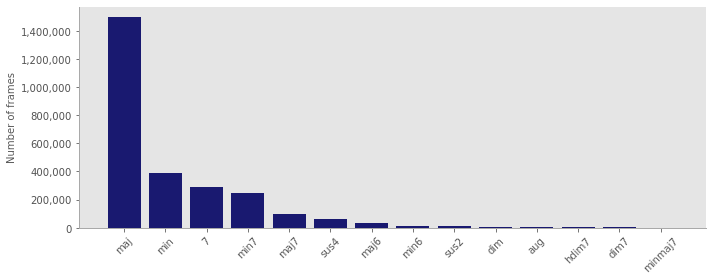

In [28]:
chord_quality_indices = {0:'7', 1:'aug', 2:'dim', 3:'dim7',
                         4:'hdim7', 5:'maj', 6:'maj6', 7:'maj7',
                         8:'min', 9:'min6', 10:'min7', 11:'minmaj7',
                         12:'sus2', 13:'sus4', 168: 'N', 169: 'X'}

# Plot MARL chord quality distribution
vals = [humphrey_bello_fold_statistics[i] for i in range(5)]
dataset_totals = vals[0] + vals[1] + vals[2] + vals[3] + vals[4]

sort_indices = np.argsort(dataset_totals)[::-1]
height = dataset_totals[sort_indices]
labels = [chord_quality_indices[i] for i in sort_indices]
x = np.arange(14)

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(labels, height, width=0.8, color='midnightblue', log=False)
ax.set_ylabel('Number of frames', **lfont)
plt.yticks(**axfont)
plt.xticks(rotation=45, **axfont)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(False)
for i, spine in enumerate(ax.spines.values()):
    if i == 0 or i == 2:
        spine.set_edgecolor('darkgrey')
    else:
        spine.set_edgecolor('white')
plt.tight_layout()
plt.show()

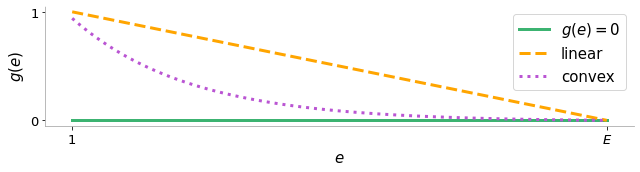

In [17]:
# Plot curriculum scheduler functions
def scheduler_function(func_type, e, E, phi):
    if func_type == 0:
        threshold = 0
    elif func_type == 1:
        threshold = 1 - (e - 1) / (E-1)
    elif func_type == 2:
        threshold = (0.95 ** e) - (phi ** E)

    return threshold

tfont = {'fontsize':16}
lfont = {'fontsize':15}
axfont = {'fontsize':13}

x = np.arange(90) + 1
labels = [r'$g(e) = 0$', 'linear', 'convex']
fig, ax = plt.subplots(figsize=(9,2.5))
colors = ['mediumseagreen', 'orange', 'mediumorchid']
line_styles = ['solid', 'dashed', 'dotted']
for i, lab in enumerate(labels):
    y = []
    for j in range(1, 91):
        y.append(scheduler_function(i,j,90,0.95))
    plt.plot(x, y, label=lab, color=colors[i], linewidth=3, linestyle=line_styles[i])
    plt.xlabel(r'$e$', **lfont)
    plt.ylabel(r'$g(e)$', **lfont)
    plt.yticks(**axfont)
    ax.set_xticks([1,90])
    ax.set_xticklabels([1, r'$E$'])
    ax.set_yticks([0,1])
    plt.xticks(**axfont)
    plt.legend(**lfont)
ax.grid(False)
for i, spine in enumerate(ax.spines.values()):
    if i == 0 or i == 2:
        spine.set_edgecolor('darkgrey')
    else:
        spine.set_edgecolor('white')
plt.tight_layout()
plt.show()

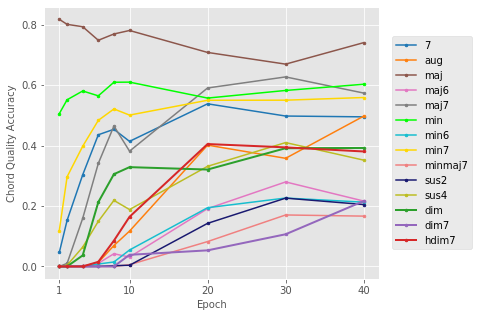

In [22]:
# Plot Curriculum Learning Visualization
chord_quality_indices = ['7', 'aug', 'maj', 'maj6', 'maj7','min', 'min6', 'min7', 'minmaj7',  'sus2', 'sus4', 'dim', 'dim7', 'hdim7']

epoch_names = ['_epoch1', '_epoch2', '_epoch4', '_epoch6', '_epoch8', '_epoch10', '_epoch20', '_epoch30', '_epoch40']
epochs = [1,2,4,6,8,10, 20, 30, 40]

d = {}

for epoch_name, epoch in zip(epoch_names, epochs):
    pickle_path = os.path.join("../../MARL", 'acqa{}.pkl'.format(epoch_name))
    with open(pickle_path, 'rb') as f:
        pkl_file = pickle.load(f)

    if epoch == 1:
        for cq in pkl_file.keys():
            if cq == 'N' or cq == 'X':
                continue 
            d[cq] = [pkl_file[cq]]
    else:
        for cq in pkl_file.keys():
            if cq == 'N' or cq == 'X':
                continue 
            d[cq].append(pkl_file[cq])
plt.style.use('ggplot')

colors = ['tab:blue', 
          'tab:orange', 
          'tab:brown',
          'tab:pink',
          'tab:gray',
          'lime',
          'tab:cyan',
          'gold',
          'lightcoral',
          'midnightblue',
          'tab:olive',
          'tab:green',
          'tab:purple',
          'tab:red']

tfont = {'fontsize':16}
lfont = {'fontsize':10}
axfont = {'fontsize':10}
fig, ax = plt.subplots(figsize=(6,5))
ax.grid(True)
for i, cq in enumerate(chord_quality_indices):
    x = epochs 
    y = d[cq]
    if i <= 10:
        plt.plot(x, y, label=cq, color=colors[i], marker='.', markersize=5)
    else:
        plt.plot(x, y, label=cq, color=colors[i], marker='.', markersize=5, linewidth=2)
    plt.ylabel('Chord Quality Accuracy', **lfont)
    plt.xlabel('Epoch', **lfont)
    plt.yticks(**axfont)
    plt.xticks(**axfont)
    ax.set_xticklabels([1,10,20,30,40])
    ax.set_xticks([1,10,20,30,40])
    plt.legend()
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, **axfont)
plt.show()